# Gaussian Process (GP) smoothing

This example deals with the case when we want to **smooth** the observed data points $(x_i, y_i)$ of some 1-dimensional function $y=f(x)$, by finding the new values $(x_i, y'_i)$ such that the new data is more "smooth" (see more on the definition of smoothness through allocation of variance in the model description below) when moving along the $x$ axis. 

It is important to note that we are **not** dealing with the problem of interpolating the function $y=f(x)$ at the unknown values of $x$. Such problem would be called "regression" not "smoothing", and will be considered in other examples.

If we assume the functional dependency between $x$ and $y$ is **linear** then, by making the independence and normality assumptions about the noise, we can infer a straight line that approximates the dependency between the variables, i.e. perform a linear regression. We can also fit more complex functional dependencies (like quadratic, cubic, etc), if we know the functional form of the dependency in advance.

However, the **functional form** of $y=f(x)$ is **not always known in advance**, and it might be hard to choose which one to fit, given the data. For example, you wouldn't necessarily know which function to use, given the following observed data. Assume you haven't seen the formula that generated it:

In [1]:
%pylab inline
figsize(12, 6);

Populating the interactive namespace from numpy and matplotlib


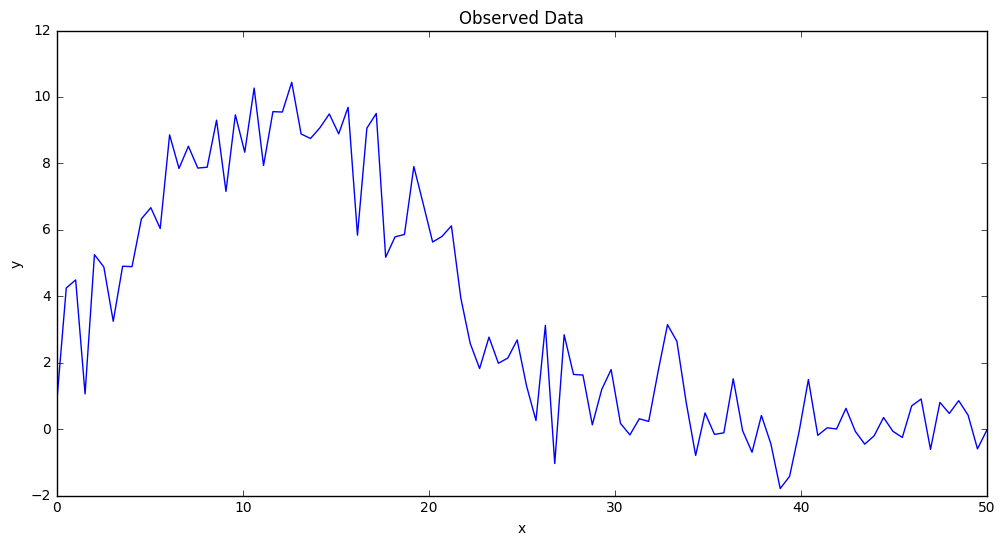

In [2]:
import numpy as np
import scipy.stats as stats

x = np.linspace(0, 50, 100)
y = (np.exp(1.0 + np.power(x, 0.5) - np.exp(x/15.0)) + 
     np.random.normal(scale=1.0, size=x.shape))

plot(x, y);
xlabel("x");
ylabel("y");
title("Observed Data");

### Let's try a linear regression first

As humans, we see that there is a non-linear dependency with some noise, and we would like to capture that dependency. If we perform a linear regression, we see that the "smoothed" data is less than satisfactory:

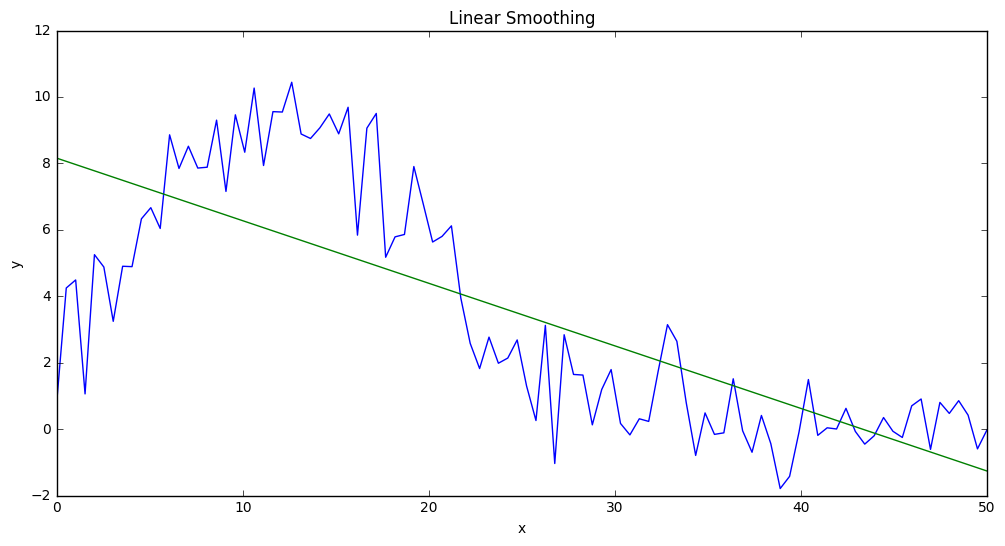

In [3]:
plot(x, y);
xlabel("x");
ylabel("y");

lin = stats.linregress(x, y)
plot(x, lin.intercept + lin.slope * x);
title("Linear Smoothing");

### Linear regression model recap

The linear regression assumes there is a linear dependency between the input $x$ and output $y$, sprinkled with some noise around it so that for each observed data point we have:

$$ y_i = a + b\, x_i + \epsilon_i $$

where the observation errors at each data point satisfy:

$$ \epsilon_i \sim N(0, \sigma^2) $$

with the same $\sigma$, and the errors are independent:

$$ cov(\epsilon_i, \epsilon_j) = 0 \: \text{ for } i \neq j $$

The parameters of this model are $a$, $b$, and $\sigma$. It turns out that, under these assumptions, the maximum likelihood estimates of $a$ and $b$ don't depend on $\sigma$. Then $\sigma$ can be estimated separately, after finding the most likely values for $a$ and $b$.

### Gaussian Process smoothing model

This model allows departure from the linear dependency by assuming that the dependency between $x$ and $y$ is a Brownian motion over the domain of $x$. This doesn't go as far as assuming a particular functional dependency between the variables. Instead, by **controlling the standard deviation of the unobserved Brownian motion** we can achieve different levels of smoothness of the recovered functional dependency at the original data points. 

The particular model we are going to discuss assumes that the observed data points are **evenly spaced** across the domain of $x$, and therefore can be indexed by $i=1,\dots,N$ without the loss of generality. The model is described as follows:

\begin{equation}
\begin{aligned}
z_i & \sim \mathcal{N}(z_{i-1} + \mu, (1 - \alpha)\cdot\sigma^2) \: \text{ for } i=2,\dots,N \\
z_1 & \sim ImproperFlat(-\infty,\infty) \\
y_i & \sim \mathcal{N}(z_i, \alpha\cdot\sigma^2)
\end{aligned}
\end{equation}

where $z$ is the hidden Brownian motion, $y$ is the observed data, and the total variance $\sigma^2$ of each ovservation is split between the hidden Brownian motion and the noise in proportions of $1 - \alpha$ and $\alpha$ respectively, with parameter $0 < \alpha < 1$ specifying the degree of smoothing.

When we estimate the maximum likelihood values of the hidden process $z_i$ at each of the data points, $i=1,\dots,N$, these values provide an approximation of the functional dependency $y=f(x)$ as $\mathrm{E}\,[f(x_i)] = z_i$ at the original data points $x_i$ only. Therefore, again, the method is called smoothing and not regression.

### Let's describe the above GP-smoothing model in PyMC3

In [4]:
import pymc3 as pm
from theano import shared
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize

Let's create a model with a shared parameter for specifying different levels of smoothing. We use very wide priors for the "mu" and "tau" parameters of the hidden Brownian motion, which you can adjust according to your application.

In [5]:
LARGE_NUMBER = 1e5

model = pm.Model()
with model:
    smoothing_param = shared(0.9)
    mu = pm.Normal("mu", sd=LARGE_NUMBER)
    tau = pm.Exponential("tau", 1.0/LARGE_NUMBER)
    z = GaussianRandomWalk("z",
                           mu=mu,
                           tau=tau / (1.0 - smoothing_param), 
                           shape=y.shape)
    obs = pm.Normal("obs", 
                    mu=z, 
                    tau=tau / smoothing_param, 
                    observed=y)

Let's also make a helper function for inferring the most likely values of $z$:

In [6]:
def infer_z(smoothing):
    with model:
        smoothing_param.set_value(smoothing)
        res = pm.find_MAP(vars=[z], fmin=optimize.fmin_l_bfgs_b)
        return res['z']

Please note that in this example, we are only looking at the MAP estimate of the unobserved variables. We are not really interested in inferring the posterior distributions. Instead, we have a control parameter $\alpha$ which lets us allocate the variance between the hidden Brownian motion and the noise. Other goals and/or different models may require sampling to obtain the posterior distributions, but for our goal a MAP estimate will suffice.

### Exploring different levels of smoothing

Let's try to allocate 50% variance to the noise, and see if the result matches our expectations.

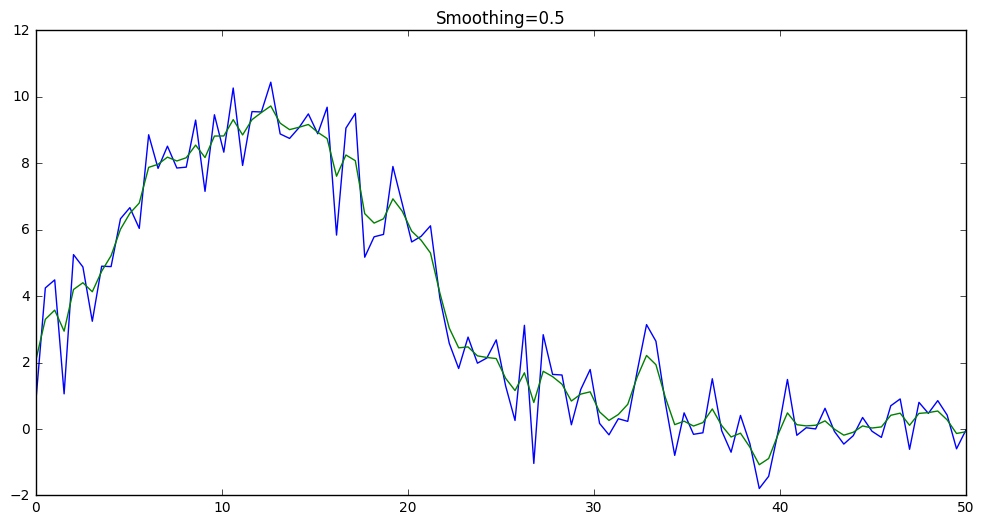

In [7]:
smoothing = 0.5
z_val = infer_z(smoothing)

plot(x, y);
plot(x, z_val);
title("Smoothing={}".format(smoothing));

It appears that the variance is split evenly between the noise and the hidden process, as expected. 

Let's try gradually increasing the smoothness parameter to see if we can obtain smoother data:

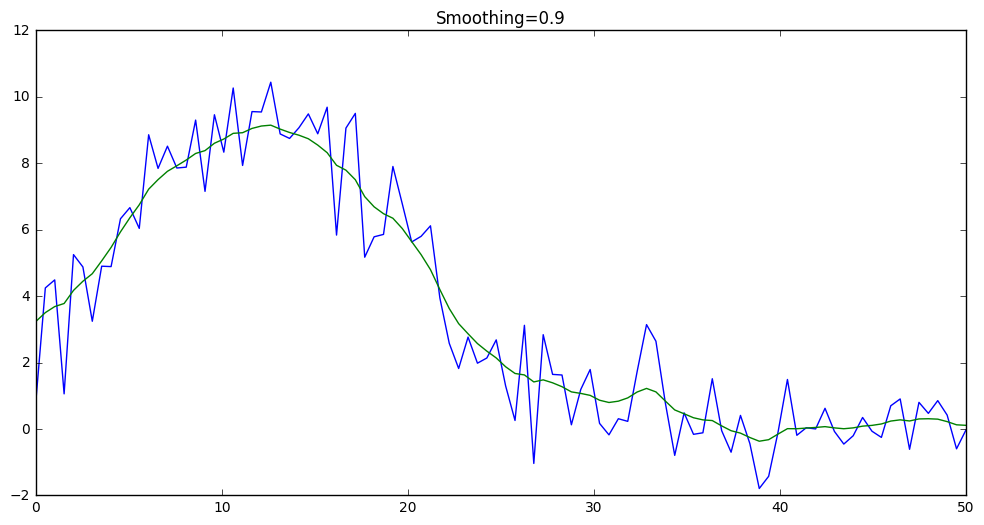

In [8]:
smoothing = 0.9
z_val = infer_z(smoothing)

plot(x, y);
plot(x, z_val);
title("Smoothing={}".format(smoothing));

### Smoothing "to the limits"

By increading the smoothing parameter, we can gradually make the inferred values of the hidden Brownian motion approach the average value of the data. This is because as we increase the smoothing parameter, we allow less and less of the variance to be allocated to the Brownian motion, so eventually it aproaches the process which almost doesn't change over the domain of $x$:

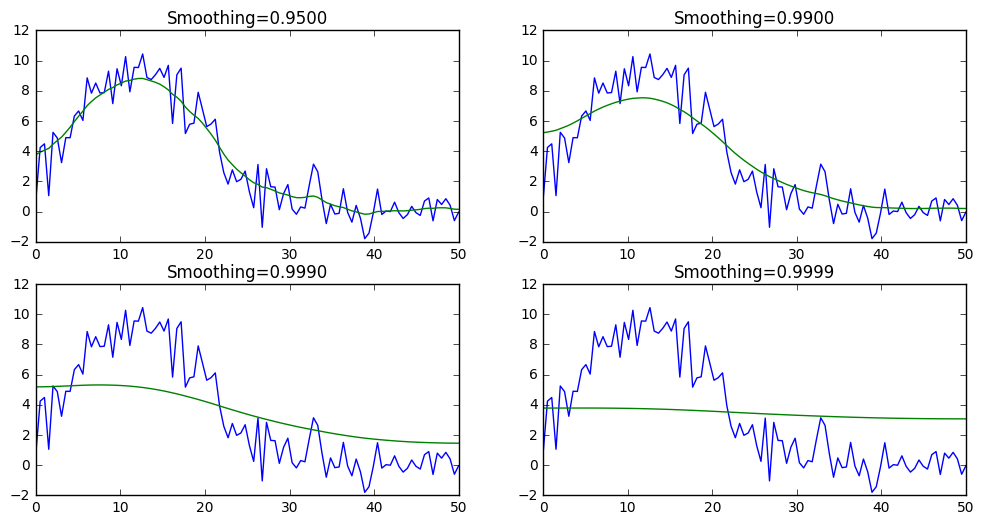

In [9]:
fig, axes = subplots(2, 2)

for ax, smoothing in zip(axes.ravel(), [0.95, 0.99, 0.999, 0.9999]):

    z_val = infer_z(smoothing)

    ax.plot(x, y)
    ax.plot(x, z_val)
    ax.set_title('Smoothing={:05.4f}'.format(smoothing))

### Interactive smoothing

Below you can interactively test different levels of smoothing. Notice, because we use a **shared Theano variable** to specify the smoothing above, the model doesn't need to be recompiled every time you move the slider, and so the **inference is fast**!

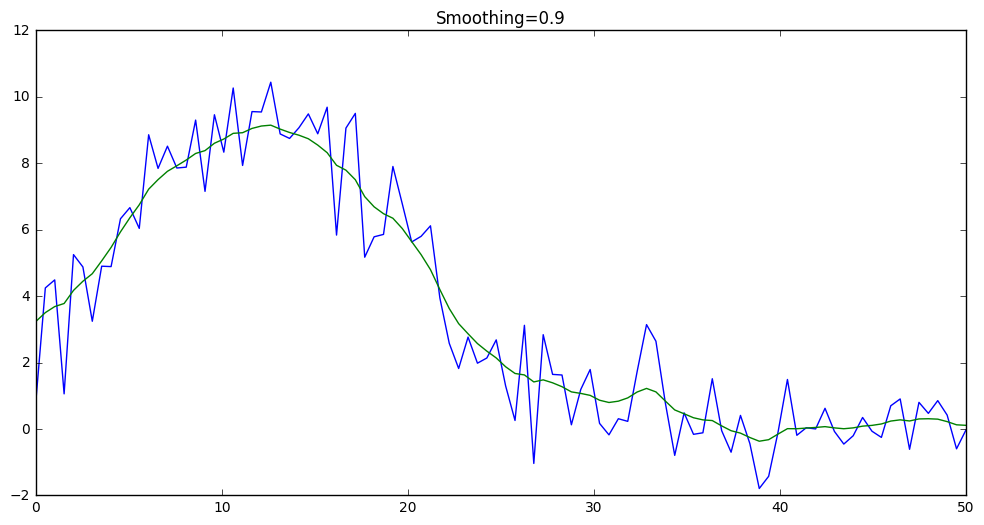

In [10]:
from IPython.html.widgets import interact
@interact(smoothing=[0.01,0.99])
def plot_smoothed(smoothing=0.9):
    z_val = infer_z(smoothing)

    plot(x, y);
    plot(x, z_val);
    title("Smoothing={}".format(smoothing));

This example originally contributed by: Andrey Kuzmenko, http://github.com/akuz